# Model Building, Hyperparameter Tuning, and Evaluation

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# set styling
plt.style.use('fivethirtyeight')
sns.set_palette('deep')

In [3]:
# add sys path to import from src directory
import sys
sys.path.append('..')

In [4]:
# import functions from src modules
from src.modeling import (
    train_test_split_data, 
    evaluate_model, 
    train_base_models,
    create_ensemble_model,
    perform_cross_validation,
    tune_hyperparameters,
    train_final_model,
    make_predictions,
    plot_feature_importance
)

## Load Processed Data

In [5]:
# load processed train and test data
try:
    train = pd.read_csv('../data/train_processed.csv')
    test = pd.read_csv('../data/test_processed.csv')
    print(f"Loaded processed data - Train: {train.shape}, Test: {test.shape}")
except FileNotFoundError:
    print("Processed data files not found. Please run the feature engineering notebook first")
    sys.exit(1)

Loaded processed data - Train: (1458, 260), Test: (1459, 258)


In [6]:
# separate target variables
y = train['SalePrice_Log']
y_orig = train['SalePrice']

In [7]:
# remove target variables from training data
X = train.drop(['SalePrice', 'SalePrice_Log'], axis=1)

In [8]:
print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (1458, 258)
Target: (1458,)


## Split Data for Training and Validation

In [9]:
# split the data
X_train, X_val, y_train, y_val, y_train_orig, y_val_orig = train_test_split_data(X, y, y_orig)

Training data: (1166, 258) samples
Validation data: (292, 258) samples


## Build and Evaluate Base Models

In [10]:
# train multiple base models
base_models, model_performances = train_base_models(X_train, y_train, X_val, y_val, y_val_orig)

Training LinearRegression...
LinearRegression - RMSE: 0.135922, R2: 0.890406, Original RMSE: 21638.01
Training Ridge...
Ridge - RMSE: 0.117232, R2: 0.918475, Original RMSE: 19072.72
Training Lasso...
Lasso - RMSE: 0.114787, R2: 0.921839, Original RMSE: 18681.32
Training ElasticNet...
ElasticNet - RMSE: 0.115147, R2: 0.921348, Original RMSE: 18776.70
Training RandomForest...
RandomForest - RMSE: 0.141294, R2: 0.881573, Original RMSE: 23241.21
Training GradientBoosting...
GradientBoosting - RMSE: 0.126023, R2: 0.905788, Original RMSE: 19166.75
Training XGBoost...
XGBoost - RMSE: 0.127045, R2: 0.904254, Original RMSE: 19300.48
Training LightGBM...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.

In [11]:
# display performance metrics in a dataframe
performance_df = pd.DataFrame(model_performances)
print("Model Performance Comparison:")
print(performance_df)

Model Performance Comparison:
                 LinearRegression         Ridge         Lasso    ElasticNet  \
RMSE                 1.359224e-01  1.172317e-01  1.147872e-01  1.151468e-01   
MAE                  8.950803e-02  7.935432e-02  7.835468e-02  7.848860e-02   
R2                   8.904063e-01  9.184745e-01  9.218390e-01  9.213485e-01   
RMSE (original)      2.163801e+04  1.907272e+04  1.868132e+04  1.877670e+04   
MAE (original)       4.682036e+08  3.637688e+08  3.489917e+08  3.525646e+08   
R2 (original)        9.152377e-01  9.341443e-01  9.368195e-01  9.361727e-01   

                 RandomForest  GradientBoosting       XGBoost      LightGBM  
RMSE             1.412939e-01      1.260235e-01  1.270450e-01  1.245692e-01  
MAE              9.464910e-02      8.298727e-02  8.410519e-02  8.343990e-02  
R2               8.815732e-01      9.057880e-01  9.042545e-01  9.079497e-01  
RMSE (original)  2.324121e+04      1.916675e+04  1.930048e+04  1.892308e+04  
MAE (original)   5.401539e

In [12]:
# sort the columns (models) based on the 'RMSE' row values
sorted_columns = performance_df.loc['RMSE'].sort_values().index
performance_df_sorted = performance_df[sorted_columns]
print("Sorted Model Performance Comparison (by RMSE):")
print(performance_df_sorted)

Sorted Model Performance Comparison (by RMSE):
                        Lasso    ElasticNet         Ridge      LightGBM  \
RMSE             1.147872e-01  1.151468e-01  1.172317e-01  1.245692e-01   
MAE              7.835468e-02  7.848860e-02  7.935432e-02  8.343990e-02   
R2               9.218390e-01  9.213485e-01  9.184745e-01  9.079497e-01   
RMSE (original)  1.868132e+04  1.877670e+04  1.907272e+04  1.892308e+04   
MAE (original)   3.489917e+08  3.525646e+08  3.637688e+08  3.580829e+08   
R2 (original)    9.368195e-01  9.361727e-01  9.341443e-01  9.351737e-01   

                 GradientBoosting       XGBoost  LinearRegression  \
RMSE                 1.260235e-01  1.270450e-01      1.359224e-01   
MAE                  8.298727e-02  8.410519e-02      8.950803e-02   
R2                   9.057880e-01  9.042545e-01      8.904063e-01   
RMSE (original)      1.916675e+04  1.930048e+04      2.163801e+04   
MAE (original)       3.673643e+08  3.725084e+08      4.682036e+08   
R2 (original)

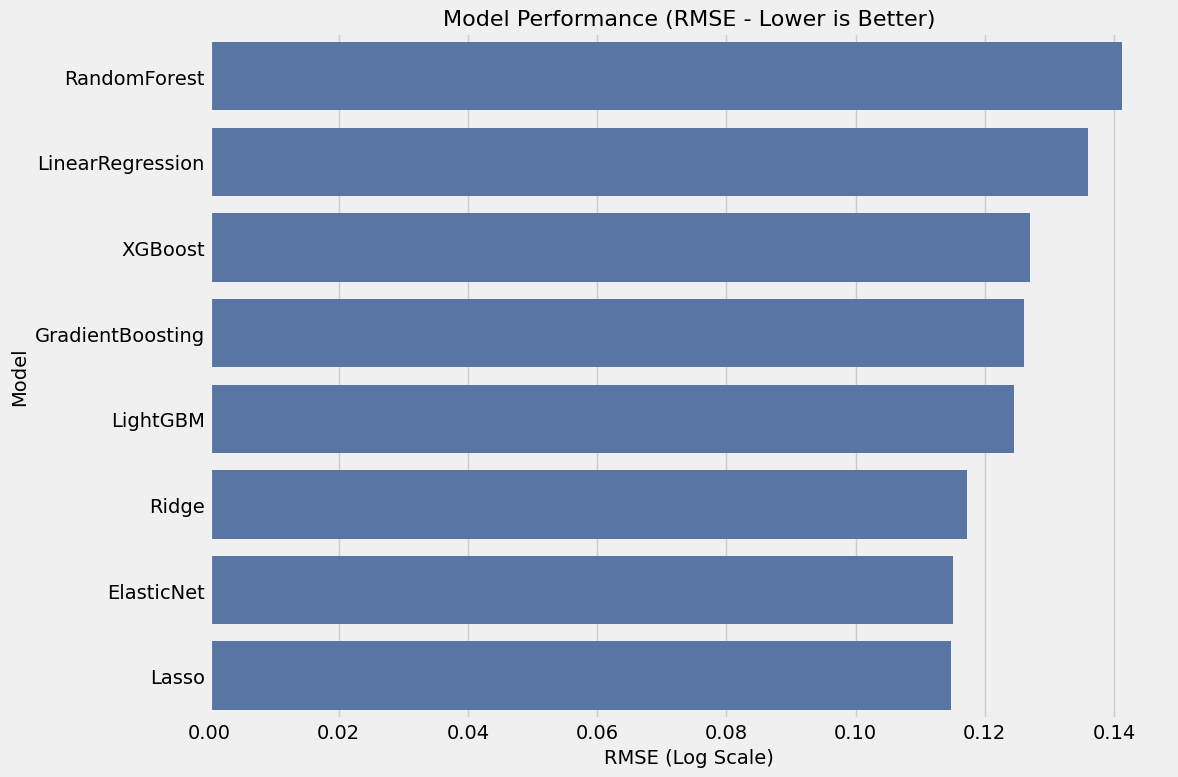

In [13]:
# visualize model performance
plt.figure(figsize=(12, 8))
performance_plot_data = performance_df.T.reset_index()
performance_plot_data.columns.name = None
performance_plot_data = performance_plot_data.sort_values('RMSE', ascending=False)
sns.barplot(x='RMSE', y='index', data=performance_plot_data)
plt.title('Model Performance (RMSE - Lower is Better)', fontsize=16)
plt.xlabel('RMSE (Log Scale)', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.tight_layout()
plt.show()

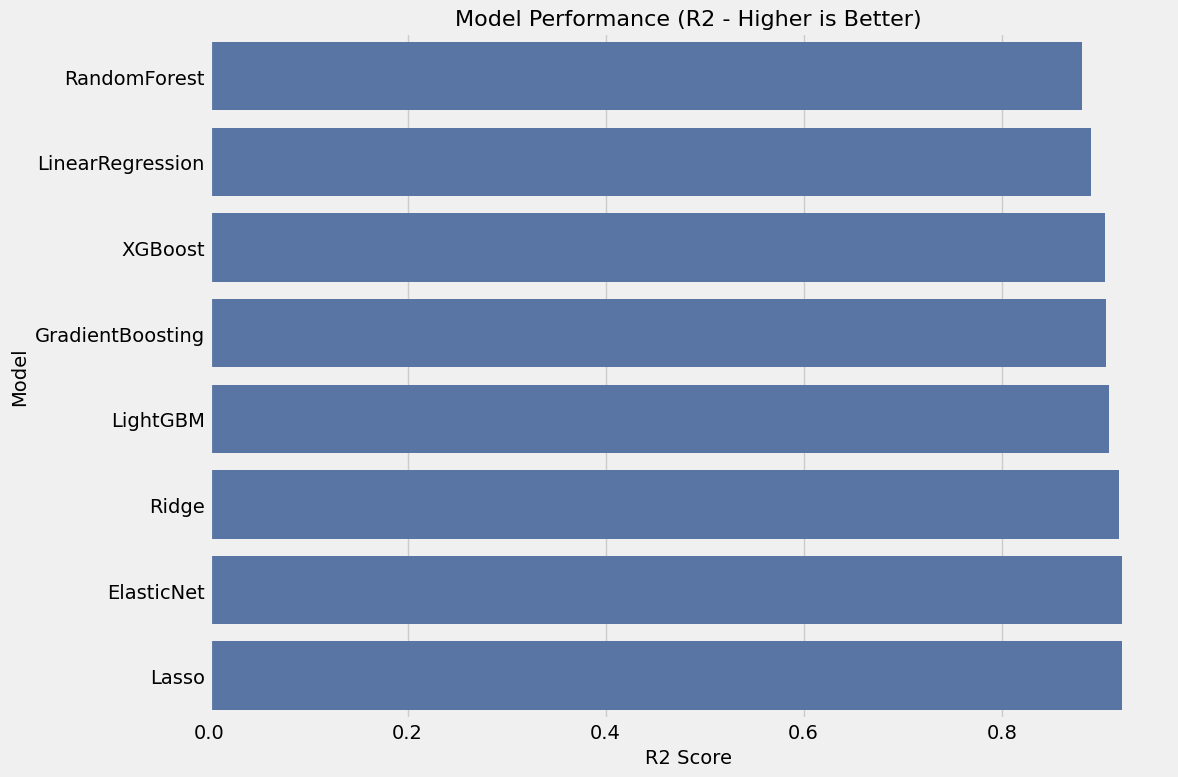

In [14]:
# visualize R2 scores
plt.figure(figsize=(12, 8))
performance_plot_data = performance_df.T.reset_index()
performance_plot_data = performance_plot_data.sort_values('R2', ascending=True)
sns.barplot(x='R2', y='index', data=performance_plot_data)
plt.title('Model Performance (R2 - Higher is Better)', fontsize=16)
plt.xlabel('R2 Score', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.tight_layout()
plt.show()

## Create Ensemble Models

In [15]:
# get the best models for the ensemble (top 5 based on RMSE)
top_models = performance_df.loc['RMSE'].sort_values().index[:5].tolist()
print(f"Using top models for ensemble: {top_models}")

Using top models for ensemble: ['Lasso', 'ElasticNet', 'Ridge', 'LightGBM', 'GradientBoosting']


In [16]:
# create ensemble models
ensemble_results = create_ensemble_model(
    {name: base_models[name] for name in top_models},
    X_train, y_train, X_val, y_val, y_val_orig
)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Model weights based on performance: {'Lasso': 0.20797206774137053, 'ElasticNet': 0.20732259798432753, 'Ridge': 0.20363548326457606, 'LightGBM': 0.19164062935499315, 'GradientBoosting': 0.18942922165473267}
Stacking coefficients: {'Lasso': 0.12060933235261334, 'ElasticNet': -0.12411502351891507, 'Ridge

In [17]:
# display ensemble performance
ensemble_df = pd.DataFrame(ensemble_results).T
print("Ensemble Model Performance:")
print(ensemble_df)

Ensemble Model Performance:
                       RMSE       MAE        R2  RMSE (original)  \
Ensemble_Average   0.113628  0.075217  0.923410     17641.925614   
Ensemble_Weighted  0.113548  0.075195  0.923518     17663.490664   
Ensemble_Stacked   0.128676  0.085456  0.901781     19835.024734   

                   MAE (original)  R2 (original)  
Ensemble_Average     12740.083808       0.943654  
Ensemble_Weighted    12749.147416       0.943517  
Ensemble_Stacked     14232.539483       0.928775  


In [21]:
# add ensemble results to performance comparison
full_performance = pd.concat([performance_df, ensemble_df.T], axis=1)
print("Updated Performance Comparison (including emsembles)")
print(full_performance)

Updated Performance Comparison (including emsembles)
                 LinearRegression         Ridge         Lasso    ElasticNet  \
RMSE                 1.359224e-01  1.172317e-01  1.147872e-01  1.151468e-01   
MAE                  8.950803e-02  7.935432e-02  7.835468e-02  7.848860e-02   
R2                   8.904063e-01  9.184745e-01  9.218390e-01  9.213485e-01   
RMSE (original)      2.163801e+04  1.907272e+04  1.868132e+04  1.877670e+04   
MAE (original)       4.682036e+08  3.637688e+08  3.489917e+08  3.525646e+08   
R2 (original)        9.152377e-01  9.341443e-01  9.368195e-01  9.361727e-01   

                 RandomForest  GradientBoosting       XGBoost      LightGBM  \
RMSE             1.412939e-01      1.260235e-01  1.270450e-01  1.245692e-01   
MAE              9.464910e-02      8.298727e-02  8.410519e-02  8.343990e-02   
R2               8.815732e-01      9.057880e-01  9.042545e-01  9.079497e-01   
RMSE (original)  2.324121e+04      1.916675e+04  1.930048e+04  1.892308e+04  

In [22]:
# get sorted version
sorted_columns = full_performance.loc['RMSE'].sort_values().index
full_performance_sorted = full_performance[sorted_columns]
print("Sorted Performance Comparison (including ensembles):")
print(full_performance_sorted)

Sorted Performance Comparison (including ensembles):
                 Ensemble_Weighted  Ensemble_Average         Lasso  \
RMSE                      0.113548          0.113628  1.147872e-01   
MAE                       0.075195          0.075217  7.835468e-02   
R2                        0.923518          0.923410  9.218390e-01   
RMSE (original)       17663.490664      17641.925614  1.868132e+04   
MAE (original)        12749.147416      12740.083808  3.489917e+08   
R2 (original)             0.943517          0.943654  9.368195e-01   

                   ElasticNet         Ridge      LightGBM  GradientBoosting  \
RMSE             1.151468e-01  1.172317e-01  1.245692e-01      1.260235e-01   
MAE              7.848860e-02  7.935432e-02  8.343990e-02      8.298727e-02   
R2               9.213485e-01  9.184745e-01  9.079497e-01      9.057880e-01   
RMSE (original)  1.877670e+04  1.907272e+04  1.892308e+04      1.916675e+04   
MAE (original)   3.525646e+08  3.637688e+08  3.580829e+08    

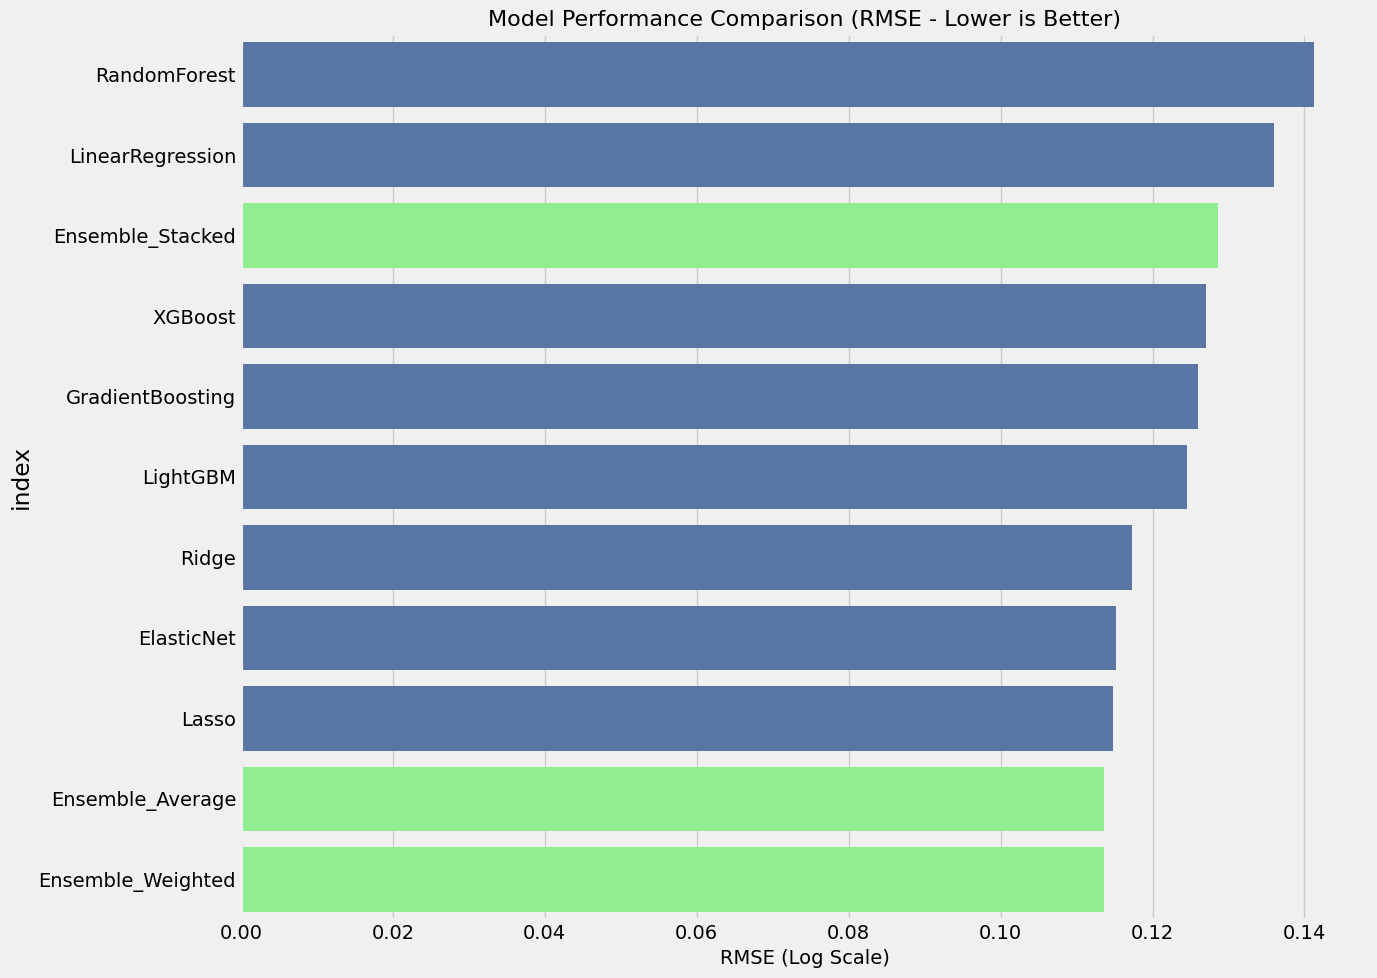

In [23]:
# visualize updated performance comparison
plt.figure(figsize=(14, 10))
full_perf_plot_data = full_performance.T.reset_index()
full_perf_plot_data = full_perf_plot_data.sort_values('RMSE', ascending=False)
bars = sns.barplot(x='RMSE', y='index', data=full_perf_plot_data)

for i, model in enumerate(full_perf_plot_data['index']):
    if str(model).startswith('Ensemble'):
        bars.patches[i].set_facecolor('lightgreen')

plt.title("Model Performance Comparison (RMSE - Lower is Better)", fontsize=16)
plt.xlabel("RMSE (Log Scale)", fontsize=14)
plt.tight_layout()
plt.show()

## Cross-Validation of Top Models

In [24]:
# get 3 best performing models for cross-validation based on RMSE
best_models = full_performance.loc['RMSE'].sort_values().index[:3].tolist()
print(f"Performing cross-validation on best models: {best_models}")

Performing cross-validation on best models: ['Ensemble_Weighted', 'Ensemble_Average', 'Lasso']


In [25]:
# perform cross-validation on best models
cv_results = perform_cross_validation(
    {name: base_models[name] if name in base_models else None for name in best_models},
    X, y
)

Performing 5-fold cross-validation for Lasso...
Lasso - Mean CV RMSE: 0.113191 (±0.007372)


In [26]:
# display cross-validation results
cv_df = pd.DataFrame(cv_results).T
cv_df = cv_df.sort_values('Mean CV RMSE')
print("Cross-Validation Results")
print(cv_df)

Cross-Validation Results
                                          CV RMSE Scores Mean CV RMSE  \
Lasso  [0.1147871812687619, 0.11203267196054921, 0.11...     0.113191   

      Std CV RMSE  
Lasso    0.007372  


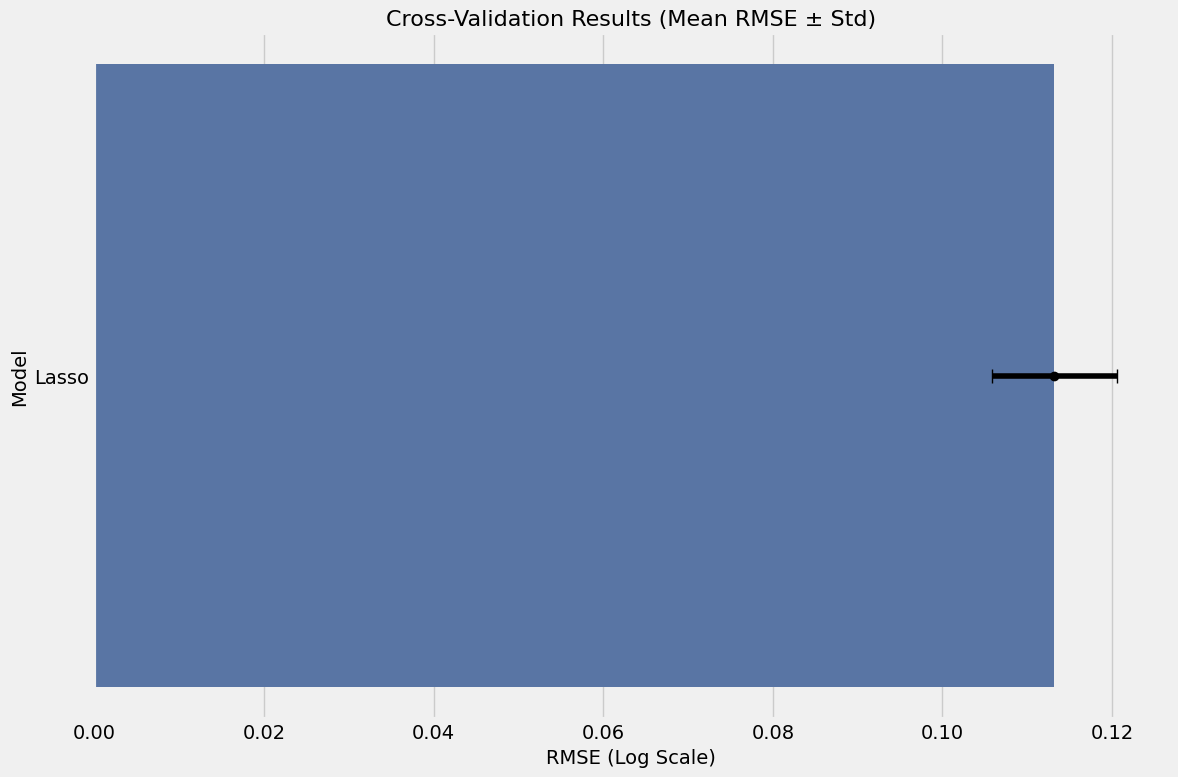

In [27]:
# visualize cross-validation results
plt.figure(figsize=(12, 8))
cv_plot = cv_df.reset_index()
sns.barplot(x='Mean CV RMSE', y='index', data=cv_plot)

for i, row in cv_plot.iterrows():
    plt.errorbar(row['Mean CV RMSE'], i, xerr=row['Std CV RMSE'],
                 fmt='o', color='black', ecolor='black', capsize=5)
    
plt.title('Cross-Validation Results (Mean RMSE ± Std)', fontsize=16)
plt.xlabel('RMSE (Log Scale)', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning for Best Model

In [28]:
# identify the best model from cross_validation
best_model_name = cv_df.index[0]
print(f"Best model based on cross-validation: {best_model_name}")

Best model based on cross-validation: Lasso


In [29]:
# tune hyperparameters for the best model
if best_model_name in base_models:
    print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
    
    best_params, best_score, tuned_model = tune_hyperparameters(
        best_model_name, base_models[best_model_name], X, y
    )
    
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score (negative RMSE): {-best_score:.6f}")
    
    # evaluate tuned model on validation set
    tuned_val_pred = tuned_model.predict(X_val)
    tuned_rmse = np.sqrt(np.mean((y_val - tuned_val_pred) ** 2))
    
    # convert to original scale for interpretation
    tuned_val_pred_orig = np.expm1(tuned_val_pred)
    tuned_rmse_orig = np.sqrt(np.mean((y_val_orig - tuned_val_pred_orig) ** 2))
    
    print(f"Tuned model RMSE on validation set (log scale): {tuned_rmse:.6f}")
    print(f"Tuned model RMSE on validation set (original $): ${tuned_rmse_orig:.2f}")
    
    # update best model with tuned version
    base_models[f"{best_model_name}_Tuned"] = tuned_model
    best_model_name = f"{best_model_name}_Tuned"
else:
    print(f"Cannot tune hyperparameters for {best_model_name} (not in base_models)")


Performing hyperparameter tuning for Lasso...

Tuning hyperparameters for Lasso...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'lasso__alpha': 0.0007}
Best CV negative MSE: -0.012834041924416908
Best CV RMSE: 0.11328743056675311
Best parameters: {'lasso__alpha': 0.0007}
Best cross-validation score (negative RMSE): 0.012834
Tuned model RMSE on validation set (log scale): 0.105276
Tuned model RMSE on validation set (original $): $17135.19


## Final Model Training and Evaluation

In [30]:
# train the final model on all training data
print("Training final model on all data...")
final_model = train_final_model(best_model_name, base_models[best_model_name], X, y)

Training final model on all data...

Training final Lasso_Tuned model on all data...


In [31]:
# save the model
os.makedirs('../models', exist_ok=True)
with open(f'../models/{best_model_name}_final.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print(f"Saved final model to ../models/{best_model_name}_final.pkl")

Saved final model to ../models/Lasso_Tuned_final.pkl


In [32]:
# visualize feature importance if available
if hasattr(final_model, 'feature_importances_'):
    feature_importance = plot_feature_importance(final_model, X.columns)

    os.makedirs('../results', exist_ok=True)
    plt.savefig('../results/feature_importance.png')
    print("Saved feature importance plot to ../results/feature_importance.png")

## Make Predictions on Test Set

In [33]:
# make predictions
test_predictions_log = make_predictions(final_model, test)
test_predictions = np.expm1(test_predictions_log)

Making predictions on test data...


In [48]:
# create submission file
original_test = pd.read_csv('../data/test.csv')

submission = pd.DataFrame({
    'Id': original_test['Id'],
    'SalePrice': test_predictions
})

In [49]:
# save submission file
os.makedirs('../results', exist_ok=True)
submission.to_csv('../results/submission.csv', index=False)
print("Saved predictions to ../results/submission.csv")

Saved predictions to ../results/submission.csv


In [36]:
# display sample predictions
print("Sample predictions:")
print(submission.head(10))

Sample predictions:
   Id      SalePrice
0   1  116430.212004
1   2  161953.008676
2   3  182518.806344
3   4  198661.024652
4   5  199155.499086
5   6  169704.905050
6   7  177746.153827
7   8  158395.599963
8   9  208670.334265
9  10  115539.478049


## Visualize Actual vs. Predicted on Validation Set

In [37]:
# get predictions on validation data for visualization
val_pred_log = final_model.predict(X_val)
val_pred = np.expm1(val_pred_log)

Saved prediction scatter plot to ../results/prediction_scatter.png


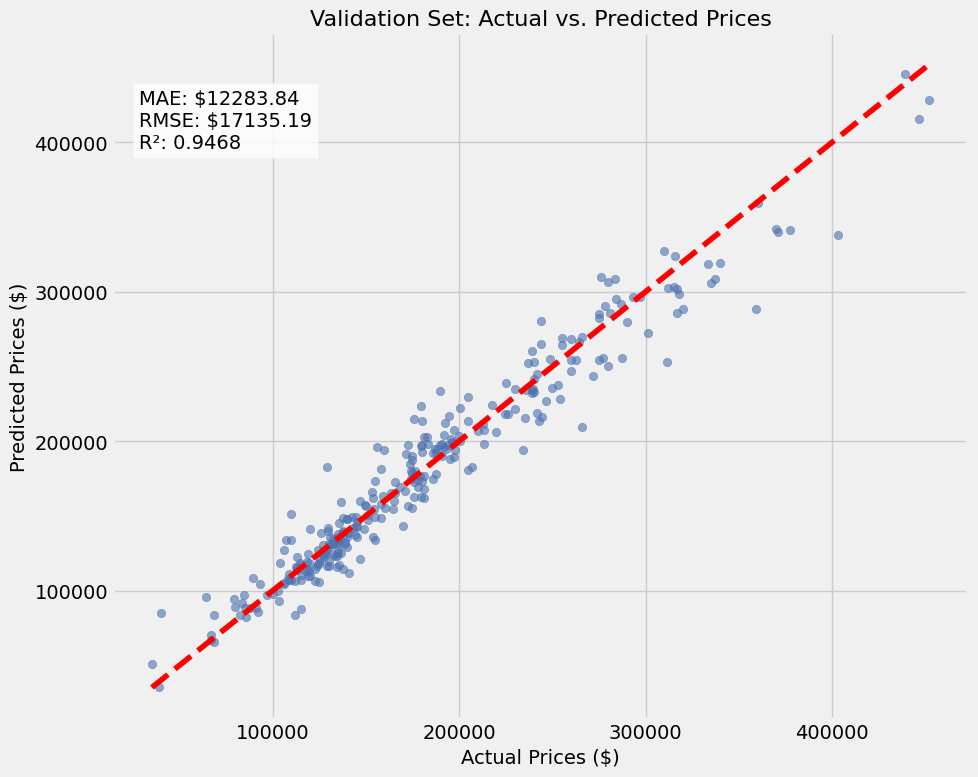

In [40]:
# create scatter plot of actual vs. predicted prices
plt.figure(figsize=(10, 8))
plt.scatter(y_val_orig, val_pred, alpha=0.6)
plt.plot([min(y_val_orig), max(y_val_orig)], [min(y_val_orig), max(y_val_orig)], 'r--')
plt.xlabel('Actual Prices ($)', fontsize=14)
plt.ylabel('Predicted Prices ($)', fontsize=14)
plt.title('Validation Set: Actual vs. Predicted Prices', fontsize=16)

# add metrics to the plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
val_mae = mean_absolute_error(y_val_orig, val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val_orig, val_pred))
val_r2 = r2_score(y_val_orig, val_pred)

plt.figtext(0.15, 0.8, 
            f"MAE: ${val_mae:.2f}\nRMSE: ${val_rmse:.2f}\nR²: {val_r2:.4f}",
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
os.makedirs('../results', exist_ok=True)
plt.savefig('../results/prediction_scatter.png')
print("Saved prediction scatter plot to ../results/prediction_scatter.png")
plt.show()

Saved residual plot to ../results/residual_plot.png


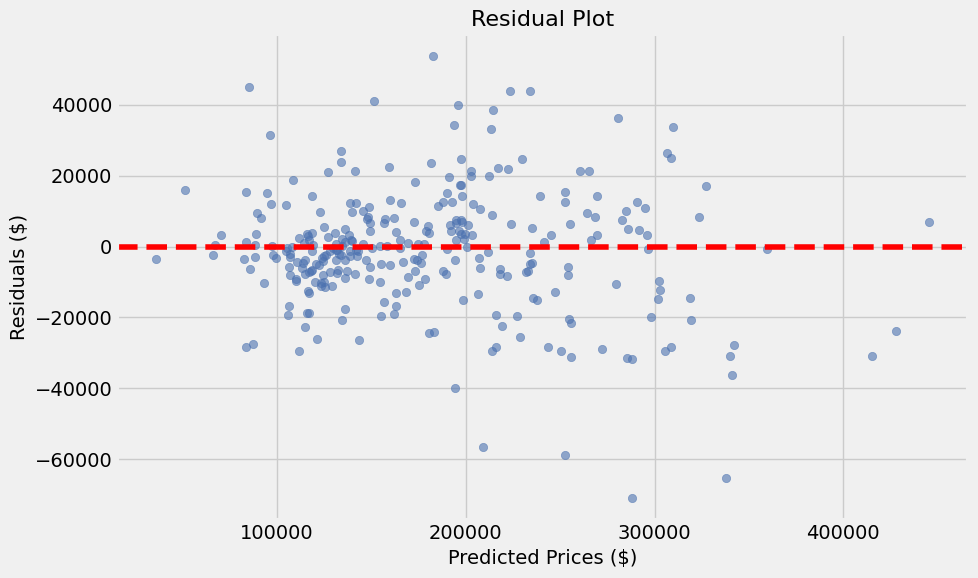

In [41]:
# create residual plot
residuals = val_pred - y_val_orig
plt.figure(figsize=(10, 6))
plt.scatter(val_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices ($)', fontsize=14)
plt.ylabel('Residuals ($)', fontsize=14)
plt.title('Residual Plot', fontsize=16)
plt.tight_layout()
plt.savefig('../results/residual_plot.png')
print("Saved residual plot to ../results/residual_plot.png")
plt.show()

## Create a Price Bracket Analysis

In [42]:
# define price brackets for analysis
price_brackets = [
    (0, 150000, 'Low'),
    (150000, 250000, 'Medium-Low'),
    (250000, 350000, 'Medium'),
    (350000, 500000, 'Medium-High'),
    (500000, float('inf'), 'High')
]

In [43]:
# create bracket labels for actual prices
y_val_brackets = pd.cut(
    y_val_orig, 
    bins=[bracket[0] for bracket in price_brackets] + [float('inf')],
    labels=[bracket[2] for bracket in price_brackets]
)

In [44]:
# calculate accuracy by price bracket
bracket_results = []
for bracket_name in y_val_brackets.cat.categories:
    # get indices for this bracket
    bracket_indices = y_val_brackets == bracket_name
    
    # calculate metrics for this bracket
    bracket_actual = y_val_orig[bracket_indices]
    bracket_pred = val_pred[bracket_indices]
    
    if len(bracket_actual) > 0:
        bracket_mae = mean_absolute_error(bracket_actual, bracket_pred)
        bracket_rmse = np.sqrt(mean_squared_error(bracket_actual, bracket_pred))
        bracket_mape = np.mean(np.abs((bracket_actual - bracket_pred) / bracket_actual)) * 100
        
        bracket_results.append({
            'Price Bracket': bracket_name,
            'Count': len(bracket_actual),
            'MAE': bracket_mae,
            'RMSE': bracket_rmse,
            'MAPE (%)': bracket_mape,
            'Avg Actual Price': bracket_actual.mean(),
            'Avg Predicted Price': bracket_pred.mean()
        })

In [45]:
# create and display results dataframe
bracket_df = pd.DataFrame(bracket_results)
print("\nModel Performance by Price Bracket:")
print(bracket_df)


Model Performance by Price Bracket:
  Price Bracket  Count           MAE          RMSE  MAPE (%)  \
0           Low    125   8801.791013  12864.447206  8.518524   
1    Medium-Low    116  12277.451966  16076.420070  6.432164   
2        Medium     42  18309.876717  22445.724460  6.306962   
3   Medium-High      9  32606.431761  39311.282843  8.372786   

   Avg Actual Price  Avg Predicted Price  
0     118732.384000        119251.577519  
1     193215.698276        195445.975018  
2     288760.523810        280095.383337  
3     397485.444444        366401.483713  


Saved price bracket analysis to ../results/price_bracket_analysis.png


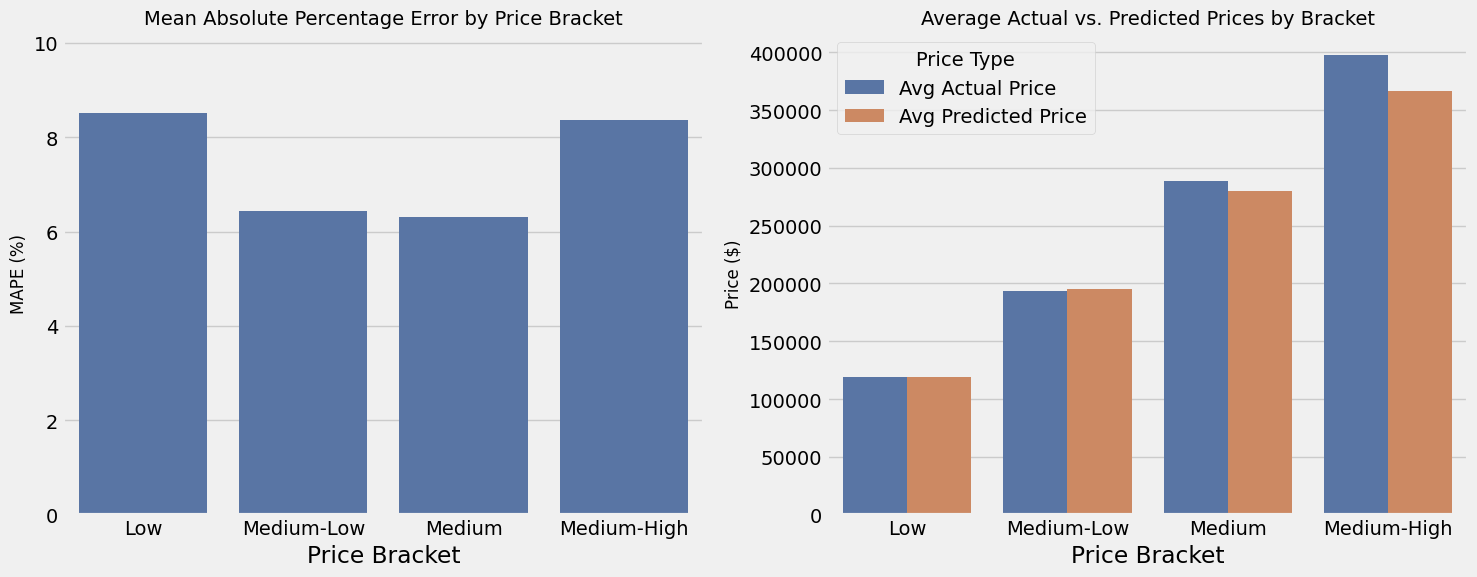

In [46]:
# plot metrics by price bracket
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# plot Mean Absolute Percentage Error by bracket
sns.barplot(x='Price Bracket', y='MAPE (%)', data=bracket_df, ax=axes[0])
axes[0].set_title('Mean Absolute Percentage Error by Price Bracket', fontsize=14)
axes[0].set_ylabel('MAPE (%)', fontsize=12)
axes[0].set_ylim(0, bracket_df['MAPE (%)'].max() * 1.2)  # Add some headroom

# plot average prices by bracket
bracket_df_melted = pd.melt(
    bracket_df, 
    id_vars=['Price Bracket'],
    value_vars=['Avg Actual Price', 'Avg Predicted Price'],
    var_name='Price Type',
    value_name='Average Price ($)'
)
sns.barplot(x='Price Bracket', y='Average Price ($)', hue='Price Type', data=bracket_df_melted, ax=axes[1])
axes[1].set_title('Average Actual vs. Predicted Prices by Bracket', fontsize=14)
axes[1].set_ylabel('Price ($)', fontsize=12)

plt.tight_layout()
plt.savefig('../results/price_bracket_analysis.png')
print("Saved price bracket analysis to ../results/price_bracket_analysis.png")
plt.show()